<h1><center>
    ECE 438 - Laboratory 4a<br/>
    Sampling and Reconstruction of Continuous-Time Signals<br/>
    <small>Last updated on January 27, 2022</small>
</center></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

<h2 style="color:salmon;"><left>1. Introduction</left></h2>

It is often desired to analyze and process continuous-time signals using a computer. However, in order to process a continuous-time signal, it must first be digitized. This means that the continuous-time signal must be sampled and quantized, forming a digital signal that can be stored in a computer. Analog systems can be converted to their discrete-time counterparts, and these digital systems then process discrete-time signals to produce discrete-time outputs. The digital output can then be converted back to an analog signal, or *reconstructed*, through a digital-to-analog converter. Figure 1 illustrates an example, containing the three general components described above: a sampling system, a digital signal processor, and a reconstruction system.


<figure>
    <img src="imgs/lab04a_figure1.png" style="width:70%" alt="Figure 1">
    <em><center>Figure 1: Example of a typical digital signal processing system</center></em>
</figure>

When designing such a system, it is essential to understand the effects of the sampling and reconstruction processes. Sampling and reconstruction may lead to different types of distortion, including low-pass filtering, aliasing, and quantization. The system designer must insure that these distortions are below acceptable levels, or are compensated through additional processing.

<h3 style="color:salmon;"><left>1.1 Sampling Overview</left></h3>

Sampling is simply the process of measuring the value of a continuous-time signal at certain instants of time. Typically, these measurements are uniformly separated by the sampling period, $T_s$. If $x(t)$ is the input signal, then the sampled signal, $y[n]$, is as follows:

\begin{equation}y[n]=x(t)|_{t=nT_s}.\end{equation}

A critical question is the following: What sampling period, $T_s$, is required to accurately represent the signal $x(t)$? To answer this question, we need to look at the frequency domain representations of $y[n]$ and $x(t)$. Since $y[n]$ is a discrete-time signal, we represent its frequency content with the discrete-time Fourier transform (DTFT), $Y(e^{j\omega})$. However, $x(t)$ is a continuous-time signal, requiring the use of the continuous-time Fourier transform (CTFT), denoted as $X(f)$. Fortunately, $Y(\omega)$ can be written in terms of $X(f)$:

\begin{align}
    Y(\omega)&=\frac{1}{T_s}\sum_{k=-\infty}^{\infty}X(f)|_{f=\frac{\omega-2\pi k}{2\pi T_s}}\\
    &=\frac{1}{T_s}\sum_{k=-\infty}^{\infty}X\left(\frac{\omega-2\pi k}{2\pi T_s}\right)\tag{1}.
\end{align}

Consistent with the properties of the DTFT, $Y(\omega)$ is periodic with a period $2\pi$. It is formed by rescaling the amplitude and frequency of $X(f)$, and then repeating it in frequency every $2\pi$. The critical issue of the relationship in (1) is the frequency content of $X(f)$. If $X(f)$ has frequency components that are above $1/(2T_s)$, the repetition in frequency will cause these components to overlap with (i.e. add to) the components below $1/(2T_s)$. This causes an unrecoverable distortion, known as *aliasing*, that will prevent a perfect reconstruction of $X(f)$. We will illustrate this later in the lab. The $1/(2T_s)$ "cutoff frequency" is known as the **_Nyquist frequency_**.

To prevent aliasing, most sampling systems first low pass filter the incoming signal to ensure that its frequency content is below the Nyquist frequency. In this case, $Y(\omega)$ can be related to $X(f)$ through the $k=0$ term in (1):

\begin{equation}
    Y(\omega)=\frac{1}{T_s}X\left(\frac{\omega}{2\pi T_s}\right)\quad\text{for }\omega\in[-\pi,\pi]
\end{equation}

Here, it is understood that $Y(e^{j\omega})$ is periodic with period $2\pi$. Note in this expression that $Y(e^{j\omega})$ and $X(f)$ are related by a simple scaling of the frequency and magnitude axes. Also, note that $\omega=\pi$ in $Y(e^{j\omega})$ corresponds to the Nyquist frequency, $f=1/(2T_s)$ in $X(f)$.

Sometimes after the sampled signal has been digitally processed, it must then converted back to an analog signal. Theoretically, this can be done by converting the discrete-time signal to a sequence of continuous-time impulses that are weighted by the sample values. If this continuous-time “impulse train” is filtered with an ideal low pass filter, with a cutoff frequency equal to the Nyquist frequency, a scaled version of the original low pass filtered signal will result. The spectrum of the reconstructed signal $S(f)$ is given by 

\begin{equation}
    S(f)=\begin{cases}Y(2\pi fT_s)&\text{for }|f|<\frac{1}{2T_s}\\
    0&\text{otherwise}\end{cases}\tag{2}
\end{equation}

<h3 style="color:salmon;"><left>1.2 Sampling and Reconstruction Using Sample-and-Hold</left></h3>

<figure>
    <img src="imgs/lab04a_figure2.png" style="width:70%">
    <em><center>Figure 2: Sampling and reconstruction using a sample-and-hold</center></em>
</figure>

In practice, signals are reconstructed using digital-to-analog converters. These devices work by reading the current sample, and generating a corresponding output voltage for a period of $T_s$ seconds. The combined effect of sampling and D/A conversion may be thought of as a single sample-and-hold device. Unfortunately, the sample-and-hold process distorts the frequency spectrum of the reconstructed signal. In this section, we will analyze the effects of using a $\text{zero}^{\text{th}}$-order sample-and-hold in a sampling and reconstruction system. Later in the laboratory, we will see how the distortion introduced by a sample-and-hold process may be reduced through the use of discrete-time interpolation.

Figure 2 illustrates a system with a low-pass input filter, a sample-and-hold device, and a low-pass output filter. If there were no sampling, this system would simply be two analog filters in cascade. We know the frequency response for this simpler system. Any differences between this and the frequency response for the entire system is a result of the sampling and reconstruction. Our goal is to compare the two frequency responses using Python. For this analysis, we will assume that the filters are $N^{\text{th}}$ order Butterworth filters with a cutoff frequency of $f_c$ , and that the sample-and-hold runs at a sampling rate of $f_s = 1/T_s$.

We will start the analysis by first examining the ideal case. Consider replacing the sample-and-hold with an ideal impulse generator, and assume that instead of the Butterworth filters we use perfect low-pass filters with a cutoff of $f_c$ . After analyzing this case we will modify the results to account for the sample-and-hold and Butterworth filter roll-off.

If an ideal impulse generator is used in place of the sample-and-hold, then the frequency spectrum of the impulse train can be computed by combining the sampling equation (1) with the reconstruction equation (2).

\begin{align}
    S(f)&=Y(2\pi fT_s)\\
    &=\frac{1}{T_s}\sum_{k=-\infty}^{\infty}X\left(\frac{2\pi fT_s-2\pi k}{2\pi T_s}\right)\\
    &=\frac{1}{T_s}\sum_{k=-\infty}^\infty X(f-kf_s),\quad\text{for }|f|\leq\frac{1}{2T_s}\\
    S(f)&=0\quad\text{for }|f|>\frac{1}{2T_s}.
\end{align}

If we assume that $f_s > 2f_c$ , then the infinite sum reduces to one term. In this case, the reconstructed signal is given by

\begin{equation}
    S(f)=\frac{1}{T_s}X(f)\tag{3}
\end{equation}

Notice that the reconstructed signal is scaled by the factor $\frac{1}{T_s}$.

Of course, the sample-and-hold does not generate perfect impulses. Instead it generates a pulse of width $T_s$, and magnitude equal to the input sample. Therefore, the new signal out of the sample-and-hold is equivalent to the old signal (an impulse train) convolved with the pulse

\begin{equation}
    p(t)=\text{rect}\left(\frac{t}{T_s}-\frac{1}{2}\right).
\end{equation}

Convolution in the time domain is equivalent to multiplication in the frequency domain, so this convolution with $p(t)$ is equivalent to multiplying by the Fourier transform $P(f)$ where

\begin{equation}
    |P(f)|=T_s|\text{sinc}(f/f_s)|.\tag{4}
\end{equation}

Finally, the magnitude of the frequency response of the N-th order Butterworth filter is given by

\begin{equation}
    |H_b(f)|=\frac{1}{1+\left(\frac{f}{f_c}\right)^N}.\tag{5}
\end{equation}

We may calculate the complete magnitude response of the sample-and-hold system by combining the effects of the Butterworth filters in equation (5), the ideal sampling system in equation (3), and the sample-and-hold pulse width in equation (4). This yields the final expression

\begin{align}
    |H(f)|&=|H_b(f)P(f)\frac{1}{T_s}H_b(f)|\\
    &=\left(\frac{1}{1+\left(\frac{f}{f_c}\right)^N}\right)^2|\text{sinc}(f/f_s)|.
\end{align}

Notice that the expression $|\text{sinc}(f/f_s)|$ produces a roll-off in frequency which will attenuate frequencies close to the Nyquist rate. Generally, this roll-off is not desirable.

<h3 style="color:red;"><left>Exercise 1</left></h3>

**Let $T_s=1\text{ sec}$, $f_c=0.45\text{ Hz}$, and $N=20$.**

**1. Compute and plot the magnitude response of the system in Figure 2 without the sample-and-hold device. Let the frequencies be ```f = np.linspace(-1, 1, 2001)```.**

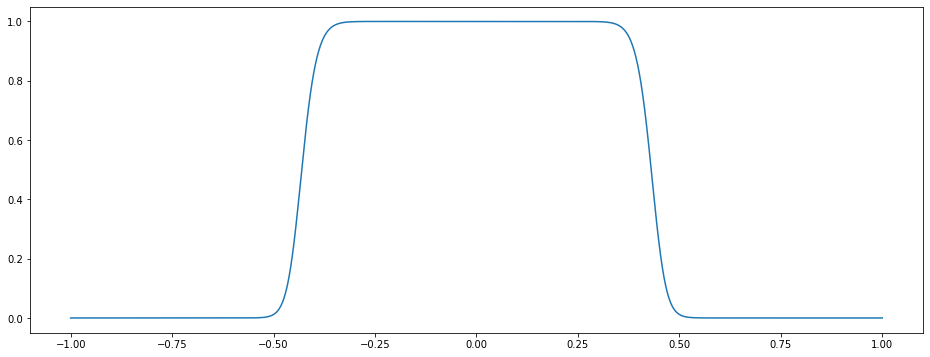

In [12]:
# write your code here
f = np.linspace(-1, 1, 2001)
Ts = 1
fc = 0.45
N = 20

Hb = 1 / (1 + np.power(f / fc, N))
H1 = Hb * Hb / Ts
plt.plot(f, H1)
plt.show()

**2. Compute and plot the magnitude response of the complete system in Figure 2. Let the frequencies be ```f = np.linspace(-1, 1, 2001)```.**

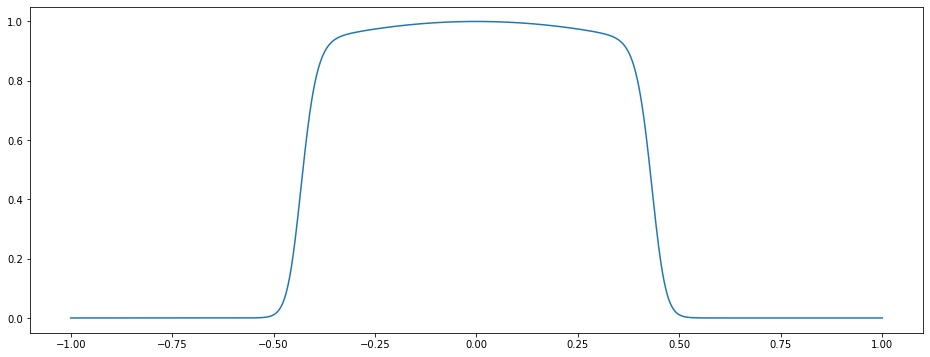

In [11]:
# write your code here
H2 = Hb * Hb * np.sinc(f / (1 / Ts))
plt.plot(f, H2)
plt.show()

**3. Comment on the shape of the two magnitude responses. How might the magnitude response of the sample-and-hold affect the design considerations of a high quality audio CD player?**

write your answer here

<h2 style="color:salmon;"><left>2. Simulink Overview</left></h2>

<figure>
    <img src="imgs/lab04a_figure3.png" style="width:70%">
    <em><center>Figure 3: Simulink utilities for lab 4</center></em>
</figure> 
    
In this lab we will use Simulink to simulate the effects of the sampling and reconstruction
processes. Simulink treats all signals as continuous-time signals. This means that “sampled”
signals are really just continuous-time signals that contain a series of finite-width pulses. The
height of each of these pulses is the amplitude of the input signal at the beginning of the
pulse. In other words, both the sampling action and the zero-order-hold reconstruction are
done at the same time; the discrete-time signal itself is never generated. This means that the
impulse-generator block is really a “pulse-generator”, or zero-order-hold device. Remember
that, in Simulink, frequency spectra are computed on continuous-time signals. This is why
many aliased components will appear in the spectra.
    

<h2 style="color:salmon;"><left>3. Sampling and Reconstruction with an Impulse Generator</left></h2>

In this section, we will experiment with the sampling and reconstruction of signals using a pulse generator. This pulse generator is the combination of an ideal impulse generator and a perfect zero-order-hold device.
In order to run the experiment, open Matlab, change current directory to `Lab4Utilities`, and then type `Lab4`. A set of Simulink blocks and experiments will come up as shown in
Fig 3.
<figure>
    <img src="imgs/lab04a_figure4.png" style="width:70%">
    <em><center>Figure 4: Simulink model for sampling and recosntruction using an impulse generator</center></em>
</figure>

Before starting this experiment, use the MATLAB command `close all` to close all figures
other than the Simulink windows. Double click on the icon named __*Sampling and Reconstruction Using An Impulse Generator*__ to bring up the first experiment as shown in Figure 4. In
this experiment, a sine wave is sampled at a frequency of 1 Hz; then the sampled discretetime signal is used to generate rectangular impulses of duration 0.3 sec and amplitude equal to the sample values. The block named __*Impulse Generator*__ carries out both the sampling of the sine wave and its reconstruction with pulses. A single __*Scope*__ is used to plot both the input and output of the impulse generator, and a __*Spectrum Analyzer*__ is used to plot the output pulse train and its spectrum.    

<h3 style="color:red;"><left>Exercise 3</left></h3>

First, run the simulation with the frequency of input sine wave set to 0.1 Hz (initial
setting of the experiment). Let the simulation run until it terminates to get an accurate plot of the output frequencies. Then print the output of __*Scope*__ and the __*Spectrum Analyzer*__. Be sure to label your plots.

**1.Submit the plot of the input/output signals and the plot of the output signal and its frequency spectrum. On the plot of the spectrum of the reconstructed signal, circle the aliases, i.e. the components that do NOT correspond to the input sine wave.**


insert your plots here

---

Ideal impulse functions can only be approximated. In the initial setup, the pulse width is 0.3 sec, which is less then the sampling period of 1 sec. Try setting the pulse width to 0.1 sec and run the simulation. Print the output of the __*Spectrum Analyzer*__.


**2.Submit the plot of the output frequency spectrum for a pulse width of 0.1 sec. Indicate on your plot what has changed and explain why.**

Insert your plots here

---

Set the pulse width back to 0.3 sec and change the frequency of the sine wave to 0.8 Hz.
Run the simulation and print the output of the __*Scope*__ and the __*Spectrum Analyzer*__.

**3.Submit the plot of the input/output signals and the plot of the output signal and its frequency spectrum. On the frequency plot, label the frequency peak that corresponds to the lowest frequency (the fundamental component) of the output signal. Explain why the lowest frequency is no longer the same as the frequency of the input sinusoid.**

Insert your plots here

---

Leave the input frequency at 0.8 Hz. Now insert a filter right after the impulse generator. Use a 10th order Butterworth filter with a cutoff frequency of 0.5 Hz. Connect the output of the filter to the __*Spectrum Analyzer*__ and the __*Mux*__. Run the simulation, and print the output of __*Scope*__ and the __*Spectrum Analyzer*__.

**4.Submit the plot of the input/output signals and the plot of the output signal and its frequency spectrum. Explain why the output signal has the observed frequency spectrum.**

Insert your plots here

<h2 style="color:salmon;"><left>4. Sampling and Reconstruction with Sample and Hold</left></h2>

<figure>
    <img src="imgs/lab04a_figure5.png" style="width:70%">
    <em><center>Figure 5: Initial Simulink model for sampling and reconstruction using a sample-and-hold. This system only measures the frequency response of the analog filters.</center></em>
</figure>

In this section, we will sample a continuous-time signal using a sample-and-hold and then reconstruct it. We already know that a sample-and-hold followed by a low-pass filter does not result in perfect reconstruction. This is because a sample-and-hold acts like a pulse generator with a pulse duration of one sampling period. This “pulse shape” of the sample-and-hold is what distorts the frequency spectrum (see Sec 1.2).

To start the second experiment, double click on the icon named __*Sampling and Reconstruction Using A Sample and Hold*__. Figure 5 shows the initial setup for this exercise. It contains 4 Scopes to monitor the processing done in the sampling and reconstruction system. It also contains a __*Network Analyzer*__ for measuring the frequency response and the impulse response of the system.

The __*Network Analyzer*__ works by generating a weighted chirp signal (shown on Scope 1) as an input to the system-under-test. The frequency spectrum of this chirp signal is known. The analyzer then measures the frequency content of the output signal (shown on Scope 4). The transfer function is formed by computing the ratio of the output frequency spectrum to the input spectrum. The inverse Fourier transform of this ratio, which is the impulse response of the system, is then computed.

In the initial setup, the __*Sample-and-Hold*__ and __*Scope 3*__ are not connected. There is no sampling in this system, just two cascaded low-pass filters. Run the simulation and observe the signals on the __*Scopes*__. Wait for the simulation to end.

<h3 style="color:red;"><left>Exercise 4</left></h3>

**1.Submit the figure containing plots of the magnitude response, the phase response, and the
impulse response of this system. Use the tall mode to obtain a larger printout by typing
`orient(’tall’)` directly before you print.**

Insert your plots here

---

Double-click the __*Sample-and-Hold*__ and set its __*Sample time*__ to 1. Now, insert the __*Sample-and-Hold*__ in between the two filters and connect __*Scope 3*__ to its output. Run the simulation and observe the signals on the __*Scopes*__.

**2.Submit the figure containing plots of the magnitude response, the phase response, and the
impulse response of this system. Explain the reason for the difference in the shape of this
magnitude response versus the previous magnitude response. Give an analytical expression
for the behavior of the magnitude plot for frequencies below 0.45 Hz.**

Insert your plots here